# Spectral clustering - basic version

### 1. Importing data
#### 1.1 Artificial data
Directories in "Project1" directory:
- https://github.com/gagolews/clustering-benchmarks
- https://github.com/gagolews/clustering-data-v1

In [4]:
# !pip install natsort
# !pip install genieclust

In [48]:
from artificial_data import *
X, labels = importBiggerArtificialData()
print(X.shape)
# X, labels = importSmallerArtificialData()


(1500, 3)


In [6]:
labels[0]

array([3, 3, 3, ..., 2, 2, 2])

#### 1.2 Real data
Data obtained from https://snap.stanford.edu/data/gemsec-Facebook.html

In [13]:
from real_data import *
# X = importFacebookTvShowData()
# X = importFacebookArtistData()

### 2. Importing libraries

In [52]:
# GENERAL
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import kneighbors_graph
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as AR
import numpy as np
import networkx as nx
import time
from statistics import mean

# VISUALIZATION
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.animation import PillowWriter
import matplotlib.ticker as ticker
from  matplotlib.ticker import FuncFormatter

### 3. Data pre-processing
#### 3.1 Faithful sampling
Following functionalities are responsible for performing faithful sampling on the originl artifical data set. The aim is to reduce the size of the data by aggregating the points into representative communities

In [8]:
# Function executes faithful sampling algorithm
# (based on: https://bmcbioinformatics.biomedcentral.com/counter/pdf/10.1186/1471-2105-11-403.pdf)
#
# X - data set
# m - maximal number of communities in a single cluster (initially 1000)
# return: list of points aggregated in communities
def faithfulSampling(X, m = 1000):

    dim = len(X[0])              # dimension of the data set
    n = len(X)                   # size of the data set
    V = n * dim                  # space volume

    h = (1/2) * (V/((m^2)))**(1/dim)   # initializing h
    m1 = m                       # setting initial communities size

    
    # iterate untill size of h will no longer be adjustable
    while((m/2) <= m1 and m1 <= m):

        communities = []                                            # initialize communities buckets
        unregistered = list(range(len(X)))
        
        # iterate until all data points are registered
        while(len(unregistered) > 0):
            randomPt = X[np.random.choice(unregistered, 1)]         # selecting random data point
            community = np.empty(0, dtype=np.int64)                 # initializing local community

            for idx in unregistered.copy():
                distance = np.sum(np.abs(X[idx]-randomPt))              # computing manhattan distance

                if(distance < h):
                    unregistered.remove(idx)                            # marking point as registered
                    community = np.append(community, [idx], axis=0)     # adding point to local community

            communities.append(community)
        
        m1 = len(communities)       # computing new maximal community length
        h = h * (m1/m)**(1/dim)     # adjusting maximal distance

    print(f"Number of communities: {len(communities)}")
    return communities

### 4. Spectral clustering
#### 4.1 Compute similarity graph
The first step considers constructing the similarity graph. Here, two approaches were implemented:
- KNN (K Nearest Neighbours) graph
- graph constructed based on the communities obtained from *faithful sampling*

In [89]:
# Function finds representative vertices of each community created after faithful sampling
#
# X - data set
# communities - communities obtained in faithful sampling
# dist_bound - maximal bound of distance from point to center (initially 10000)
# return: list of representative vertices (points)
def getRepresentativesForCommunities(X, communities, dist_bound = 10000):
    vertices = []

    # itereating over communities
    for community in communities:
       points = X[community]                                    # selecting all points for given community
       centralPoint = np.average(points, axis=0)                # calculating center of for given community space

       min = dist_bound                                         # initial min distance     
       centroid = X[community[0]]                               # initial centroid point
       
       for v in community:
           point = X[v]
           distance = np.sum(np.abs(point-centralPoint))        # computing manhattan distanc
           
           if distance < min:                                   # if distance is smaller than current minimum - updating point and distance
               min = distance
               centroid = point
       
       vertices.append(centroid)                                # adding centroid of community to common list

    return vertices

# Function constructs the graph representation by connecting the vertices using KNN approach
#
# X - data set
# M - number of neighbours (initially 5)
# return: 1) ndarray adjacency matrix representing the graph and 2) ndarray matrix with euclidean distances
def adjacencyMatrixUsingMnearestNeighbors(X, M = 5):
    
    knn = NearestNeighbors(n_neighbors=M)
    knn.fit(X)
    dist_indx_arr = knn.kneighbors(X, return_distance=True, n_neighbors = M)
    
    A = kneighbors_graph(X, n_neighbors=(M-1), p=2, mode='connectivity', include_self=False) 
    A = A.toarray() # for some reason, is not symmetric
    A = np.maximum( A, A.T )
    
    return A, dist_indx_arr # dist_indx_arr will be useful while connecting the graph


# Function constructs the graph representation by connecting the vertices using KNN approach
# with additional assertion of number of neighbours
#
# X - data set
# M - number of neighbours (initially 5)
# M_search_thresh - threshold of max number of neighbours (denoted by MST = M+N in the report!)
# return: 1) ndarray adjacency matrix representing the graph and 2) ndarray matrix with euclidean distances
def adjacencyMatrixUsingMnearestNeighborsWithThreshold(X, M = 5, M_search_thresh = 7):

    assert M_search_thresh >= M

    knn = NearestNeighbors(n_neighbors=M)
    knn.fit(X)
    dist_indx_arr = knn.kneighbors(X, return_distance=True, n_neighbors = M_search_thresh + 1)
    
    A = kneighbors_graph(X, n_neighbors=(M-1), p=2, mode='connectivity', include_self=False) 
    A = A.toarray() # for some reason, is not symmetric
    A = np.maximum( A, A.T )
    
    return A, dist_indx_arr # dist_indx_arr will be useful while connecting the graph
    

# Function constructs the graph by using representatives of communities obtained after faithful sampling
# (representatives are used in KNN)
#
# X - data set
# communities - communities obtained in faithful sampling
# M - number of neighbours used in KNN (initially 5)
# dist_bound - maximal bound of distance from point to center (initially 10000)
# return: 2d ndarray being adjacency matrix for communities
def adjacencyMatrixUsingSimilarityCommunities(X, communities, M = 5, dist_bound = 10000):
    vertices = getRepresentativesForCommunities(X, communities, dist_bound)
    return adjacencyMatrixUsingMnearestNeighbors(np.array(vertices), M)


# Function constructs the graph by using representatives of communities obtained after faithful sampling
# (representatives are used in KNN with threshold)
#
# X - data set
# communities - communities obtained in faithful sampling
# M - number of neighbours used in KNN (initially 5)
# dist_bound - maximal bound of distance from point to center (initially 10000)
# M_search_thresh - threshold of max. number of neighbours, denoted by MST = M+N in the report!
# return: 2d ndarray being adjacency matrix for communities
def adjacencyMatrixUsingSimilarityCommunitiesWithThreshold(X, communities, M = 5, dist_bound = 10000, M_search_thresh = 7):
    vertices = getRepresentativesForCommunities(X, communities, dist_bound)
    return adjacencyMatrixUsingMnearestNeighborsWithThreshold(np.array(vertices), M, M_search_thresh)

##### 4.1.1 Fill labels for communities
After performing the spectral clustering on representatives, the method is responsible for assigning labels to remaining community members 

In [90]:
# Function assign labels to remaining community members
#
# labels - labels after spectral clustering
# communities - communities obtained in faithful sampling
# size - size of the data set
# return: ndarray of labels
def reassignLabelsForCommunities(labels, communities, size):
    allLabels = np.empty((size), dtype=np.int64)

    # itereating over communities
    for i in range(len(labels)):
       label = labels[i]
       community = communities[i]

       for v in community:
           allLabels[v] = label

    np.argmax(allLabels)
    return allLabels

#### 4.2 Graph connectivity
Following methods are responsible for optimizing graph connectivity

##### 4.2.1 Trivial method

In [91]:
# Function implements trivial method of connecting the graph
#
# A - adjacency matrix
# returns: adjacency matrix with additional connections
def connectTheGraph(A):
    # trivial case of adding an edge:
    W = A
    G = nx.from_numpy_array(W)
    graphs = list(nx.connected_components(G))
    for i in range(len(graphs)-1):

        for g in graphs[i]:
            for f in graphs[i+1]:
                W[f,g] = 1
                W[g,f] = 1
                break
            break
    return W

##### 4.2.2 Connecting graph using distances

In [92]:
# Function finds additional edges that are to be added to the graph based on the distances
# between data points
#
# d - tuple (distance , index) with ndarray matrices containing distances and indices of additional neighbors
# M - number of neighbours in KNN
# MST - maximal search thershold (i.e. max. number of neighbours KNN, !denoted by MST = M+N in the report! )
# return: lists of vertices from which/to which the edge should be created
def FWTFfind(d, M, MST):
    distances = d[0][:, 1:]
    indexes = d[1][:, 1:]

    fw = list()
    tw = list()

    for m_idx in range(M, MST): # M+1 ?
        from_which = distances[:,m_idx].argsort()
        to_which = indexes[:, m_idx][from_which]

        fw.append(from_which)
        tw.append(to_which)
    return fw, tw


# Function creates final edges that are to be added to the graph based on vertices indicators and given percentage
# (i.e. list of vertices between which the connections are to be established)
#
# fw - from which vertices the connections are to be established
# percentage - fraction of added edges
# return: list of edged that are to be added to the graph
def defineEdgesToAdd(fw, percentage):
    vertices = len(fw[0])
    
    n_of_edges = float(len(fw))* vertices
    n_of_edges_to_add = int(n_of_edges*percentage)
    
    edges_to_add = list()
    
    for i in range(int(n_of_edges_to_add//vertices) ):
        edges_to_add.append(vertices)   
        n_of_edges_to_add = n_of_edges_to_add - vertices
    
    if n_of_edges_to_add != 0:
        edges_to_add.append(int(n_of_edges_to_add))
    
    return edges_to_add


# Function connects the graph by adding given list of additional edges
#
# A - adjacency matrix of the graph
# fw - list of vertices from which the edges are to be created (initially None)
# tw - list of vertices to which the edges are to be created (initially None)
# edges_to_add - list of edges that are to be added
# returns: connected graph representation
def connectTheGraphUsingDistances(A, fw=None,tw=None, edges_to_add=list()):
    W = A
    
    for i in range(len(edges_to_add)):
        for j in range(edges_to_add[i]):
            W[fw[i][j],tw[i][j]] = 1
            W[tw[i][j],fw[i][j]] = 1
    
    # trivial case of adding an edge:
    G = nx.from_numpy_array(W)
    graphs = list(nx.connected_components(G))
    
    # case when graph is already connected
    if len(graphs) == 1:
        return W
    
    # its still not connected - connect it trivially
    for i in range(len(graphs)-1):
        for g in graphs[i]:
            for f in graphs[i+1]:
                W[f,g] = 1
                W[g,f] = 1
                break
            break
        
    return W

##### 4.2.3 Connecting graph basing only on A

In [93]:
# Function connects the graph basing only on its adjacency matrix (0 and 1 values, symmetric matrix)
# Idea: nodes with the highest degrees of a given component c_i are connected by an edge with all nodes with highest degree of component c_j
#
# A - adjacency matrix
# use_fraction - flag indicating if all edges are to be connected or only their fraction (selected randomly, about ~ 1/k^2 of all possible edges) 
# k_clusters - number of clusters
# returns: connected graph
def connectTheGraphUsingOnlyAdjacencyMatrix(A, use_fraction = False, k_clusters = None):
    
    fraction_of_edges = 1/(float(k_clusters))**2 if use_fraction else None

    W = A
    G = nx.from_numpy_array(W)
    graphs = list(nx.connected_components(G))

    vertices_list = list()

    # iterating over connected components to get vertices with the highest degree
    for i in range(nx.number_connected_components(G)):
        degree_sequence = sorted([d for _, d in G.subgraph(graphs[i]).degree()], reverse=True)
        dmax = max(degree_sequence)
        dict_ = dict(G.subgraph(graphs[i]).degree)
        
        vertices_list.append([k for k, v in dict_.items() if v == dmax ])

    # connecting each of the vertices of the highest degree between components
    for i in range(len(vertices_list)):
        for j in range(i+1, len(vertices_list)):
            for k in vertices_list[i]:
                for l in vertices_list[j]:

                    # adding edge in 3 cases:
                    # 1. when all edges are to be added (use_fraction = False)
                    # 2. it is the first iteration (i = 0)
                    # 3. probability is within given threshold (random.uniform(0,1) <= fraction_of_edges)

                    if use_fraction == False or (use_fraction == True and (i == 0 or np.random.uniform(0,1) <= fraction_of_edges)):
                        W[k,l] = 1
                        W[l,k] = 1
                   

    print(nx.is_connected(nx.from_numpy_array(W))) # True

    return W

#### 4.3 Node representation
The methods are responsible for preparing the node representation of the connected graph.

In [94]:
# Function computes the Laplacian matrix based on the given graph representation
#
# A - connected graph represented by adjacency matrix
# returns: Laplacian matrix
def graphLaplacian(A):
    D = np.eye(A.shape[0]) * A.sum(axis=0)  # diagonal matrix of degrees
    return D  - A                           # L = D - A
    
    
# Function calculates eigenvalues and eigenvectors of Laplacian matrix
#
# L - Laplacian matrix representation
# returns: eigenvalues and eigenvectors
def calculateEigenVectorsOfGraphLaplacian(L):
    eigenValues, eigenVectors = np.linalg.eig(L)
    eigenValues, eigenVectors = eigenValues.real, eigenVectors.real
    
    idx = eigenValues.argsort()[::1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:, idx]
    
    return eigenValues, eigenVectors
    
    
# Function prepares node representation
#
# eigenVectors - eigenvectors of Laplacian matrix
# nodeRepresentationDim - dimension of representation
# n_of_components=1 - number of connected components in the graph
# returns: node representation
def nodeRepresentation(eigenVectors, nodeRepresentationDim, n_of_components=1):
    m = n_of_components                                         # we assume n of connected components = 1
    Z = eigenVectors[:,m:(nodeRepresentationDim + m)]           # we omit m first eigenvectors, where m is the number of components of graph from A
    return Z

# Function verifies if given matrix is symmetric
#
# A - matrix of interest
def check_symmetric(A, tol=1e-8):
    return np.all(np.abs(A-A.T) < tol)

#### 4.4 Spectral clustering
Methods responsible for performing spectral clustering

In [95]:
# Function prepares node representation used in trivial spectral clustering
#
# X - data set
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralNR(X, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors(X, M=M)
    A_connected = connectTheGraph(A)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
    return Z


# Function prepares node representation used in spectral clustering with faithful sampling data reduction
#
# X - data set
# communities - communities obtained in faithful sampling
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralNRFaithfulSampling(X, communities, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingSimilarityCommunities(X, communities, M=M)
    A_connected = connectTheGraph(A)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim, n_of_components=1)
    return Z

# Function prepares node representation used in spectral clustering using method of connecting the graph only by the knowledge of adjacency matrix
#
# X - data set
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralNRUsingOnlyA(X, M=3, nodeRepresentationDim=3):
    
    A, d = adjacencyMatrixUsingMnearestNeighbors(X, M=M)
    A_connected = connectTheGraphUsingOnlyAdjacencyMatrix(A)
    L = graphLaplacian(A_connected)
    w,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)

    return Z

# Function prepares node representation used in spectral clustering using method of connecting the graph only by the knowledge of adjacency matrix
#
# X - data set
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# n_of_clusters - number of clusters used in clustering (initially 3)
# return: labels assigned to data
def spectralNRUsingOnlyAWithRestricedEdges(X, M=3, nodeRepresentationDim=3, n_of_clusters=3):
    
    A,_ = adjacencyMatrixUsingMnearestNeighbors(X, M=M)
    A_connected = connectTheGraphUsingOnlyAdjacencyMatrix(A, use_fraction=True, k_clusters=n_of_clusters)
    L = graphLaplacian(A_connected)
    _,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v, nodeRepresentationDim, n_of_components=1)

    return Z


# Function performs simplest (trivial) spectral clustering algorithm
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralClustering(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    Z = spectralNR(X, M, nodeRepresentationDim)
    print(f'Shape of node representation: {Z.shape}')

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    return kmeans.labels_

# Function performs spectral clustering algorithm with the use of faithful sampling (data reduction step)
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# communities_no - bound of number of communities (initially 1000)
# return: labels assigned to data
def spectralClusteringWithFaithful(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, communities_no=1000):
    
    communities = faithfulSampling(X, communities_no)
    
    Z = spectralNRFaithfulSampling(X, communities, M, nodeRepresentationDim)
    print(f'Shape of node representation: {Z.shape}')

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    labels = reassignLabelsForCommunities(kmeans.labels_, communities, len(X)) 

    return labels


# Function performs spectral clustering algorithm using graph connectivity method that is basing on distances between edges
# (modification focuses on adding given fraction/percentage of prioritized edges, where the 
# priority is based on each node's distance)
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# MST - maximal search thershold (i.e. max. number of neighbours KNN) (initially 4) -- !denoted by MST = M+N in the report!
# perc - percentage of prioritized edges to be added
# return: labels assigned to data
def spectralClusteringUsingDistances(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, MST=4, perc = None):
    
    percent = 1/(float(n_of_clusters))**2 if perc == None else perc
    A, d = adjacencyMatrixUsingMnearestNeighborsWithThreshold(X, M=M, M_search_thresh=MST)
    fw, tw = FWTFfind(d, M, MST)
        
    edges_to_add = defineEdgesToAdd(fw, percent)
    A_connected = connectTheGraphUsingDistances(A, fw, tw, edges_to_add)
        
    print(f'A.sum() = {A_connected.sum()}')
    print(f'A is symmetric: {check_symmetric(A_connected)}')

    L = graphLaplacian(A_connected)
    _,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v, nodeRepresentationDim, n_of_components=1)
        
    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    return Z, kmeans.labels_

# Function performs spectral clustering algorithm using graph connectivity method that is basing on distances between edges with combined percentages
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# MST - maximal search thershold (i.e. max. number of neighbours KNN) (initially 4) -- !denoted by MST = M+N in the report!
# return: labels assigned to data
def spectralClusteringUsingDistancesCombinedPercentages(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, MST=4):

    A, d = adjacencyMatrixUsingSimilarityCommunities(X, M=M, M_search_thresh=MST)
    fw, tw = FWTFfind(d, M, MST)

    
    percs = np.linspace( 1/(float(n_of_clusters))**2 , 1/(float(n_of_clusters)), 5)
    
    for perc in percs:
        edges_to_add = defineEdgesToAdd(fw=fw, percentage=perc)
        A = connectTheGraphUsingDistances(A, fw, tw, edges_to_add)

    L = graphLaplacian(A)
    _,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)    
    return kmeans.labels_

# Function performs spectral clustering algorithm using graph connectivity method that is basing on distances between edges with combined percentages. Additionally, method uses faithful sampling for data reduction
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# communities_no - bound of number of communities (initially 1000)
# return: labels assigned to data
def spectralClusteringUsingFaithfulAndDistancesCombinedPercentages(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, MST=4, communities_no=8000):

    communities = faithfulSampling(X, communities_no)
    A, d = adjacencyMatrixUsingSimilarityCommunitiesWithThreshold(X, communities, M=M, M_search_thresh=MST)
    fw, tw = FWTFfind(d, M, MST)

    percs = np.linspace( 1/(float(n_of_clusters))**2 , 1/(float(n_of_clusters)), 5)
    
    for perc in percs:
        edges_to_add = defineEdgesToAdd(fw=fw, percentage=perc)
        A = connectTheGraphUsingDistances(A, fw, tw, edges_to_add)

    L = graphLaplacian(A)
    _,v = calculateEigenVectorsOfGraphLaplacian(L)
    Z = nodeRepresentation(v,nodeRepresentationDim,n_of_components=1)
    print(f'Shape of node representation: {Z.shape}')

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    all_labels = reassignLabelsForCommunities(kmeans.labels_, communities, len(X)) 
   
    return all_labels

# Function performs spectral clustering algorithm using graph connectivity method that is basing only on the adjacency matrix A
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralClusteringUsingOnlyA(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):

    Z = spectralNRUsingOnlyA(X, M, nodeRepresentationDim)
    print(f'Shape of node representation: {Z.shape}')

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    return kmeans.labels_


# Function performs spectral clustering algorithm using graph connectivity method that is basing only on the adjacency matrix A and additionally restrics the number of edge connections
#
# X - data set
# n_of_clusters - number of clusters used in clustering (initially 3)
# M - number of neighbours used in KNN (initially 3)
# nodeRepresentationDim - dimension of node representation (initially 3)
# return: labels assigned to data
def spectralClusteringUsingOnlyAAndRestricedConnections(X, n_of_clusters=3, M=3, nodeRepresentationDim=3):
    
    Z = spectralNRUsingOnlyAWithRestricedEdges(X, M, nodeRepresentationDim, n_of_clusters)
    print(f'Shape of node representation: {Z.shape}')

    kmeans = KMeans(n_clusters=n_of_clusters, random_state=0, n_init=100).fit(Z)
    return kmeans.labels_



In [17]:
spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=10)

Shape of node representation: (1500, 3)


array([0, 0, 0, ..., 2, 0, 0])

In [18]:
spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=10)

Number of communities: 64
Shape of node representation: (64, 3)


array([2, 1, 2, ..., 2, 2, 1], dtype=int64)

In [26]:
Z, spectral_labels = spectralClusteringUsingDistances(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=3, perc=0.1)

print(Z)
print(spectral_labels)
print(labels[0][0:20])

A.sum() = 3136.0
A is symmetric: True
[[ 0.03615904  0.03841756 -0.03036594]
 [ 0.03615743  0.03841096 -0.03035362]
 [ 0.03615313  0.03839334 -0.03032078]
 ...
 [-0.03370546  0.02170993  0.00990147]
 [-0.02630965  0.00089077 -0.02921304]
 [-0.03249892  0.01797996  0.00128181]]
[0 0 0 ... 1 1 1]
[3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3]


In [97]:
spectralClusteringUsingFaithfulAndDistancesCombinedPercentages(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=3)

Number of communities: 124
Shape of node representation: (124, 3)


array([0, 0, 0, ..., 1, 2, 2], dtype=int64)

In [65]:
spectralClusteringUsingDistancesCombinedPercentages(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=3)

array([2, 2, 2, ..., 1, 1, 1])

In [40]:
spectralClusteringUsingOnlyAAndRestricedConnections(X, n_of_clusters=3, nodeRepresentationDim=3, M=10)

True
Shape of node representation: (1500, 3)


array([0, 0, 0, ..., 1, 0, 2])

# Various experiments and results are below

### 5. Testing methods with AR

In [17]:
spectral_labels = spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=3)

AR(spectral_labels, labels[0])

Shape of node representation: (1500, 3)


0.6625395292517445

In [ ]:
spectral_labels = spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=50, communities_no=8000)

AR(spectral_labels, labels[0])

Number of communities: 123
Shape of node representation: (123, 3)


0.36742439597354937

In [27]:
Z, spectral_labels = spectralClusteringUsingDistances(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=3, perc=0.1)

AR(spectral_labels, labels[0])

A.sum() = 3136.0
A is symmetric: True


0.5730272468665356

In [66]:
spectral_labels = spectralClusteringUsingDistancesCombinedPercentages(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=3)

AR(spectral_labels, labels[0])

0.9293313435692463

In [111]:
spectral_labels = spectralClusteringUsingFaithfulAndDistancesCombinedPercentages(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=10, communities_no=8500)

AR(spectral_labels, labels[0])

Number of communities: 127
Shape of node representation: (127, 3)


0.21117218312955513

In [41]:
spectral_labels = spectralClusteringUsingOnlyA(X, n_of_clusters=3, nodeRepresentationDim=3, M=10)

AR(spectral_labels, labels[0])

True
Shape of node representation: (1500, 3)


0.24448965232996842

In [42]:
spectral_labels = spectralClusteringUsingOnlyAAndRestricedConnections(X, n_of_clusters=3, nodeRepresentationDim=3, M=10)

AR(spectral_labels, labels[0])

True
Shape of node representation: (1500, 3)


0.2851638451538544

#### 5.1 AR vs M in M-nearest neighbors
##### 5.1.1 Trivial spectral clustering

In [ ]:
# verifying the obtained results for different numbers of neighbours in KNN
ms = np.linspace(2,100, 50)
ars = []
print(ms)

for m in ms:
    spectral_labels = spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=int(m))
    print(f'M = {str(m)}')
    ars.append(AR(spectral_labels, labels[0]))


[  2.   4.   6.   8.  10.  12.  14.  16.  18.  20.  22.  24.  26.  28.
  30.  32.  34.  36.  38.  40.  42.  44.  46.  48.  50.  52.  54.  56.
  58.  60.  62.  64.  66.  68.  70.  72.  74.  76.  78.  80.  82.  84.
  86.  88.  90.  92.  94.  96.  98. 100.]
Shape of node representation: (1500, 3)
M = 2.0
Shape of node representation: (1500, 3)
M = 4.0
Shape of node representation: (1500, 3)
M = 6.0
Shape of node representation: (1500, 3)
M = 8.0
Shape of node representation: (1500, 3)
M = 10.0
Shape of node representation: (1500, 3)
M = 12.0
Shape of node representation: (1500, 3)
M = 14.0
Shape of node representation: (1500, 3)
M = 16.0
Shape of node representation: (1500, 3)
M = 18.0
Shape of node representation: (1500, 3)
M = 20.0
Shape of node representation: (1500, 3)
M = 22.0
Shape of node representation: (1500, 3)
M = 24.0
Shape of node representation: (1500, 3)
M = 26.0
Shape of node representation: (1500, 3)
M = 28.0
Shape of node representation: (1500, 3)
M = 30.0
Shape of node 

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, '')]

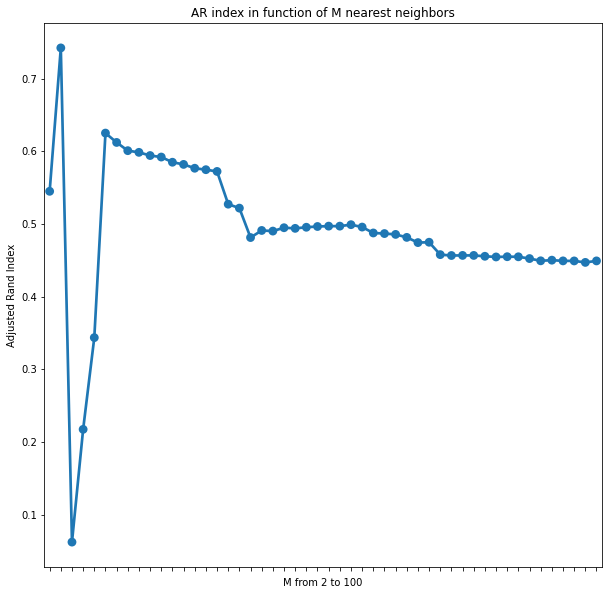

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = sns.pointplot(x = ms, y = ars)
ax.set_xlabel("M from 2 to 100")
ax.set_ylabel("Adjusted Rand Index")
ax.set_title("AR index in function of M nearest neighbors")
ax.set_xticklabels("")

##### 5.1.2 Spectral clustering using different connectivity methods

In [50]:
# Spectral clustering trivial connectivity

ars1 = []
for m in range(2,20):
    spectral_labels = spectralClustering(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    ars1.append(AR(spectral_labels, labels[0]))

Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)


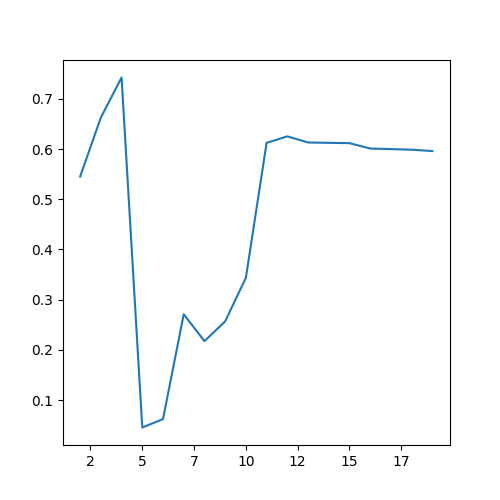

In [57]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars1).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [49]:
# Spectral clustering using connectivity with distances

ars2 = []
for m in range(2,20):
    _, spectral_labels = spectralClusteringUsingDistances(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+1)

    ars2.append(AR(spectral_labels, labels[0]))

A.sum() = 3164.0
A is symmetric: True
A.sum() = 4342.0
A is symmetric: True
A.sum() = 5898.0
A is symmetric: True
A.sum() = 7548.0
A is symmetric: True
A.sum() = 9264.0
A is symmetric: True
A.sum() = 10992.0
A is symmetric: True
A.sum() = 12654.0
A is symmetric: True
A.sum() = 14444.0
A is symmetric: True
A.sum() = 16126.0
A is symmetric: True
A.sum() = 17868.0
A is symmetric: True
A.sum() = 19580.0
A is symmetric: True
A.sum() = 21328.0
A is symmetric: True
A.sum() = 23046.0
A is symmetric: True
A.sum() = 24750.0
A is symmetric: True
A.sum() = 26484.0
A is symmetric: True
A.sum() = 28180.0
A is symmetric: True
A.sum() = 29952.0
A is symmetric: True
A.sum() = 31650.0
A is symmetric: True


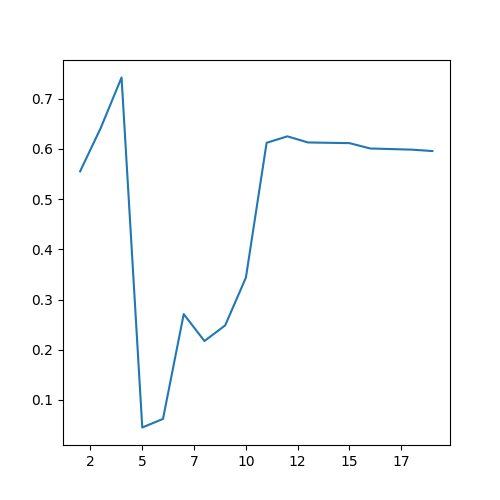

In [58]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars2).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [51]:
# Spectral clustering using connectivity with distances for different percentage

ars2_2 = []
for m in range(2,20):
    _, spectral_labels = spectralClusteringUsingDistances(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+1, perc=1/(float(3))**2)
    
    ars2_2.append(AR(spectral_labels, labels[0]))

A.sum() = 3164.0
A is symmetric: True
A.sum() = 4342.0
A is symmetric: True
A.sum() = 5898.0
A is symmetric: True
A.sum() = 7548.0
A is symmetric: True
A.sum() = 9264.0
A is symmetric: True
A.sum() = 10992.0
A is symmetric: True
A.sum() = 12654.0
A is symmetric: True
A.sum() = 14444.0
A is symmetric: True
A.sum() = 16126.0
A is symmetric: True
A.sum() = 17868.0
A is symmetric: True
A.sum() = 19580.0
A is symmetric: True
A.sum() = 21328.0
A is symmetric: True
A.sum() = 23046.0
A is symmetric: True
A.sum() = 24750.0
A is symmetric: True
A.sum() = 26484.0
A is symmetric: True
A.sum() = 28180.0
A is symmetric: True
A.sum() = 29952.0
A is symmetric: True
A.sum() = 31650.0
A is symmetric: True


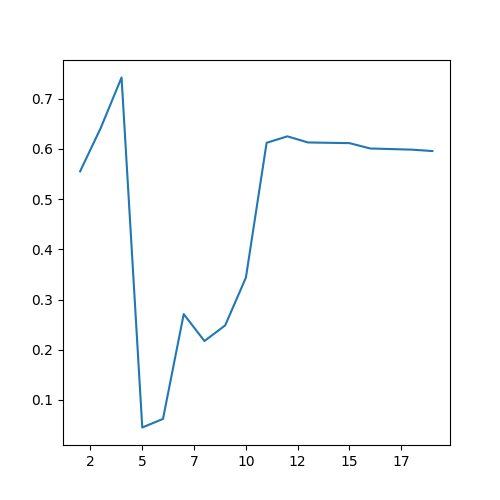

In [59]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars2_2).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [54]:
# Spectral clustering using only knowledge about matrix A

ars3 = []
for m in range(2,20):
    spectral_labels = spectralClusteringUsingOnlyA(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    
    ars3.append(AR(spectral_labels, labels[0]))

True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)


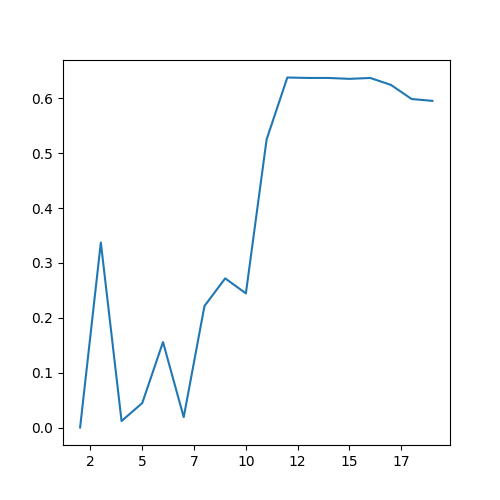

In [60]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars3).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [61]:
# Spectral clustering using only knowledge about matrix A with restriced amount of edges

ars4 = []
for m in range(2,20):
    spectral_labels = spectralClusteringUsingOnlyAAndRestricedConnections(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    
    ars4.append(AR(spectral_labels, labels[0]))

True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)


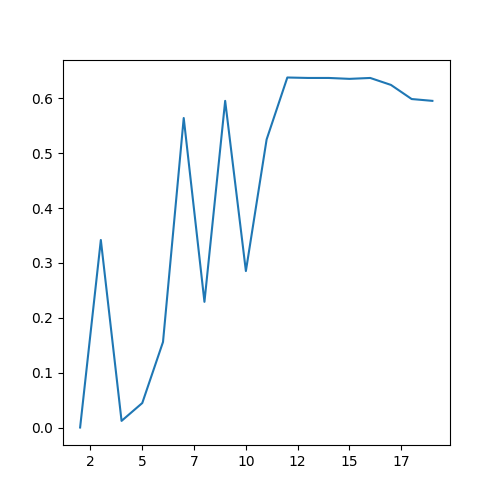

In [62]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars4).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [67]:
# Spectral clustering using connectivity with distances for combined percentages (m+1)

ars5_1 = []
for m in range(2,20):
    spectral_labels = spectralClusteringUsingDistancesCombinedPercentages(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+1)

    ars5_1.append(AR(spectral_labels, labels[0]))

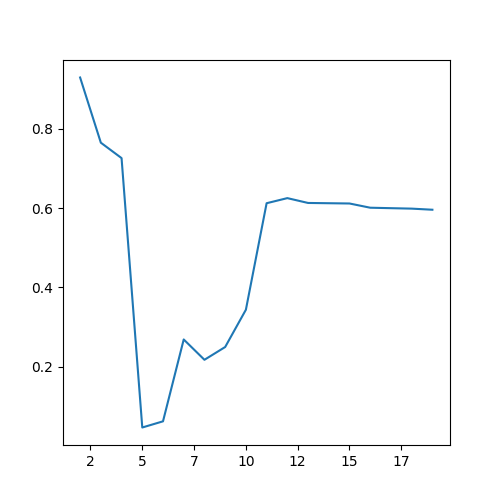

In [68]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars5_1).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [69]:
# Spectral clustering using connectivity with distances for combined percentages (m+2)

ars5_2 = []
for m in range(2,20):
    spectral_labels = spectralClusteringUsingDistancesCombinedPercentages(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+2)

    ars5_2.append(AR(spectral_labels, labels[0]))

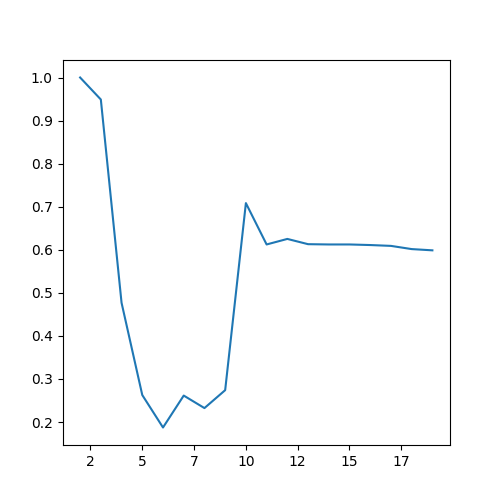

In [70]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars5_2).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [71]:
# Spectral clustering using connectivity with distances for combined percentages (m+3)

ars5_3 = []
for m in range(2,20):
    spectral_labels = spectralClusteringUsingDistancesCombinedPercentages(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+3)

    ars5_3.append(AR(spectral_labels, labels[0]))

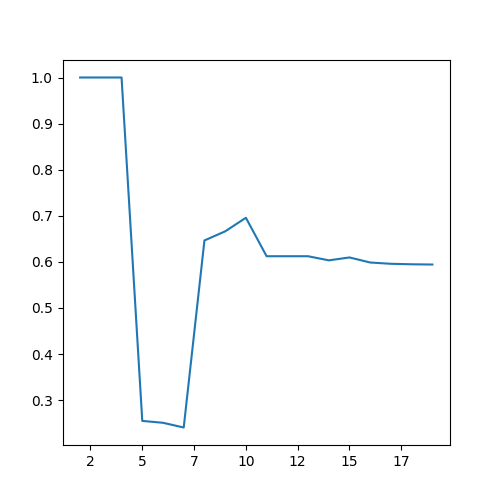

In [72]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars5_3).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

In [73]:
# Spectral clustering using connectivity with distances for combined percentages (m+4)

ars5_4 = []
for m in range(2,20):
    spectral_labels = spectralClusteringUsingDistancesCombinedPercentages(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+4)

    ars5_4.append(AR(spectral_labels, labels[0]))

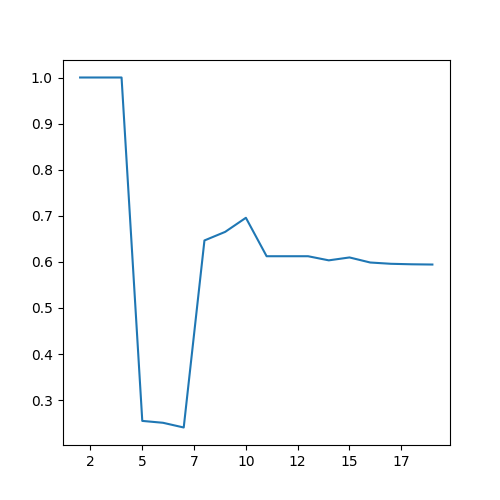

In [74]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(5,5,5)

ax = sns.lineplot(x=list(range(2,20)), y = ars5_4).xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x)))

##### 5.1.3 Different connectivity methods combined on single plot

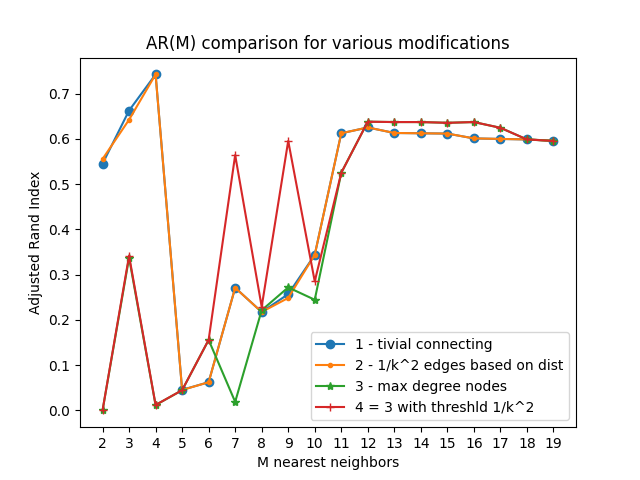

In [75]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(ars1), marker='o')
ax.plot(xs, np.array(ars2), marker='.')
ax.plot(xs, np.array(ars3), marker='*')
ax.plot(xs, np.array(ars4), marker='+')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges based on dist', '3 - max degree nodes', '4 = 3 with threshld 1/k^2'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('Adjusted Rand Index')

ax.set_title("AR(M) comparison for various modifications")

plt.xticks(xs, (xs).astype(int))
plt.show()

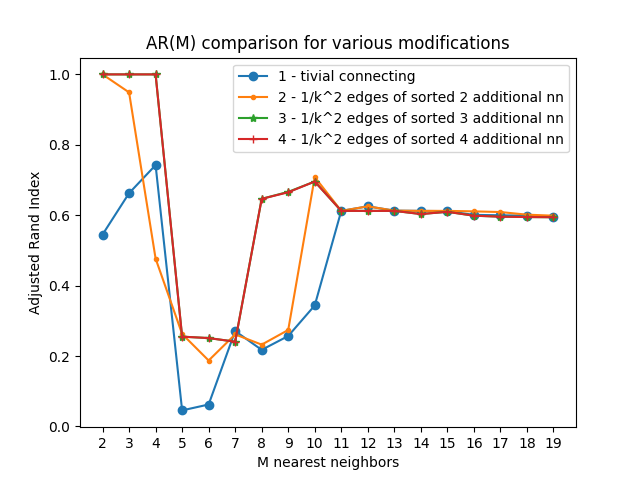

In [76]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(ars1), marker='o')
ax.plot(xs, np.array(ars5_2), marker='.')
ax.plot(xs, np.array(ars5_3), marker='*')
ax.plot(xs, np.array(ars5_4), marker='+')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges of sorted 2 additional nn', '3 - 1/k^2 edges of sorted 3 additional nn', '4 - 1/k^2 edges of sorted 4 additional nn'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('Adjusted Rand Index')

ax.set_title("AR(M) comparison for various modifications")

plt.xticks(xs, (xs).astype(int))
plt.show()

##### 5.1.4 Time comparision of different connectivity methods

In [77]:
# Spectral clustering trivial time analysis

t1 = []
for m in range(2,20):
    
    # get the start time
    st = time.time()
    spectralClustering(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    # get the end time
    et = time.time()
    
    t1.append(et-st)

Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)
Shape of node representation: (1500, 3)


In [78]:
# Spectral clustering using distances time analysis

t2 = []
for m in range(2,20):
    
    # get the start time
    st = time.time()
    spectralClusteringUsingDistances(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+ 1)
    # get the end time
    et = time.time()
    
    t2.append(et-st)

A.sum() = 3164.0
A is symmetric: True
A.sum() = 4342.0
A is symmetric: True
A.sum() = 5898.0
A is symmetric: True
A.sum() = 7548.0
A is symmetric: True
A.sum() = 9264.0
A is symmetric: True
A.sum() = 10992.0
A is symmetric: True
A.sum() = 12654.0
A is symmetric: True
A.sum() = 14444.0
A is symmetric: True
A.sum() = 16126.0
A is symmetric: True
A.sum() = 17868.0
A is symmetric: True
A.sum() = 19580.0
A is symmetric: True
A.sum() = 21328.0
A is symmetric: True
A.sum() = 23046.0
A is symmetric: True
A.sum() = 24750.0
A is symmetric: True
A.sum() = 26484.0
A is symmetric: True
A.sum() = 28180.0
A is symmetric: True
A.sum() = 29952.0
A is symmetric: True
A.sum() = 31650.0
A is symmetric: True


In [79]:
# Spectral clustering using only A time analysis

t3 = []
for m in range(2,20):
    
    # get the start time
    st = time.time()
    spectralClusteringUsingOnlyA(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    # get the end time
    et = time.time()
    
    t3.append(et-st)

True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)


In [80]:
# Spectral clustering using only A with restricted connections time analysis

t4 = []
for m in range(2,20):
    
    # get the start time
    st = time.time()
    spectralClusteringUsingOnlyAAndRestricedConnections(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3)
    # get the end time
    et = time.time()
    
    t4.append(et-st)

True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)
True
Shape of node representation: (1500, 3)


In [81]:
# Spectral clustering using distances with combined percentages time analysis (m+2)

t5_2 = []
for m in range(2,20):
    print(f'm = {m}')
    # get the start time
    st = time.time()
    spectralClusteringUsingDistancesCombinedPercentages(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+2)
    # get the end time
    et = time.time()
    
    t5_2.append(et-st)

m = 2
m = 3
m = 4
m = 5
m = 6
m = 7
m = 8
m = 9
m = 10
m = 11
m = 12
m = 13
m = 14
m = 15
m = 16
m = 17
m = 18
m = 19


In [82]:
# Spectral clustering using distances with combined percentages time analysis (m+3)

t5_3 = []
for m in range(2,20):
    print(f'm = {m}')
    # get the start time
    st = time.time()
    spectralClusteringUsingDistancesCombinedPercentages(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+3)
    # get the end time
    et = time.time()
    
    t5_3.append(et-st)

m = 2
m = 3
m = 4
m = 5
m = 6
m = 7
m = 8
m = 9
m = 10
m = 11
m = 12
m = 13
m = 14
m = 15
m = 16
m = 17
m = 18
m = 19


In [83]:
# Spectral clustering using distances with combined percentages time analysis (m+4)

t5_4 = []
for m in range(2,20):
    print(f'm = {m}')
    # get the start time
    st = time.time()
    spectralClusteringUsingDistancesCombinedPercentages(X=X, n_of_clusters=3, M=m, nodeRepresentationDim=3, MST=m+4)
    # get the end time
    et = time.time()
    
    t5_4.append(et-st)

m = 2
m = 3
m = 4
m = 5
m = 6
m = 7
m = 8
m = 9
m = 10
m = 11
m = 12
m = 13
m = 14
m = 15
m = 16
m = 17
m = 18
m = 19


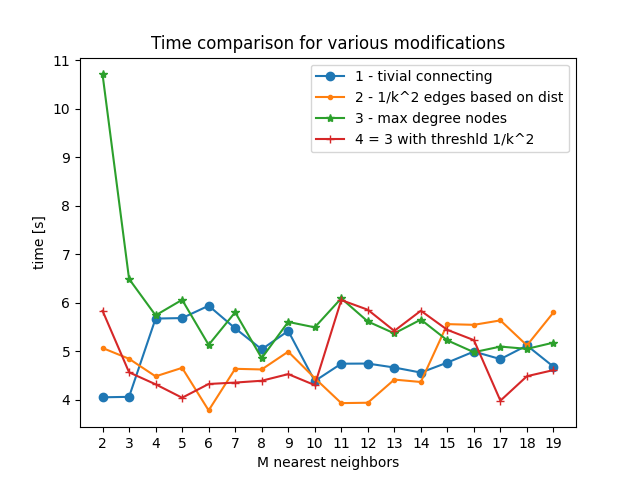

In [84]:
# Comparision of time analysis

xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(t1), marker='o')
ax.plot(xs, np.array(t2), marker='.')
ax.plot(xs, np.array(t3), marker='*')
ax.plot(xs, np.array(t4), marker='+')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges based on dist', '3 - max degree nodes', '4 = 3 with threshld 1/k^2'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('time [s]')

ax.set_title("Time comparison for various modifications")

plt.xticks(xs, (xs).astype(int))
plt.show()

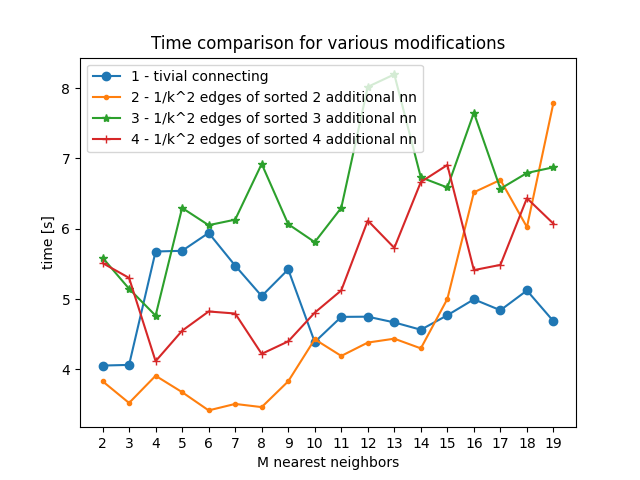

In [85]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(t1), marker='o')
ax.plot(xs, np.array(t5_2), marker='.')
ax.plot(xs, np.array(t5_3), marker='*')
ax.plot(xs, np.array(t5_4), marker='+')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges of sorted 2 additional nn', '3 - 1/k^2 edges of sorted 3 additional nn', '4 - 1/k^2 edges of sorted 4 additional nn'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('time [s]')

ax.set_title("Time comparison for various modifications")

plt.xticks(xs, (xs).astype(int))
plt.show()

#### 5.2 AR vs Max. community bound in faithful sampling

In [ ]:
# verifying the obtained results for different numbers of communities in faithful sampling
ms = np.linspace(100, 10000, 50)
samples_no = 30
ars = []
print(ms)

for m in ms:
    sum = 0
    for i in range(samples_no):
        spectral_labels = spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=3, communities_no=int(m))
        sum += AR(spectral_labels, labels[0])
        
    print(f'Communities no. = {str(m)}')
    ars.append(sum / samples_no)


[  100.           302.04081633   504.08163265   706.12244898
   908.16326531  1110.20408163  1312.24489796  1514.28571429
  1716.32653061  1918.36734694  2120.40816327  2322.44897959
  2524.48979592  2726.53061224  2928.57142857  3130.6122449
  3332.65306122  3534.69387755  3736.73469388  3938.7755102
  4140.81632653  4342.85714286  4544.89795918  4746.93877551
  4948.97959184  5151.02040816  5353.06122449  5555.10204082
  5757.14285714  5959.18367347  6161.2244898   6363.26530612
  6565.30612245  6767.34693878  6969.3877551   7171.42857143
  7373.46938776  7575.51020408  7777.55102041  7979.59183673
  8181.63265306  8383.67346939  8585.71428571  8787.75510204
  8989.79591837  9191.83673469  9393.87755102  9595.91836735
  9797.95918367 10000.        ]
Iteration count: 1
Number of communities: 16
Shape of node representation: (16, 3)
Number of labeled points: 1500
Iteration count: 1
Number of communities: 17
Shape of node representation: (17, 3)
Number of labeled points: 1500
Iteration 

[Text(0, 0, ''),
 Text(1, 0, ''),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, '')]

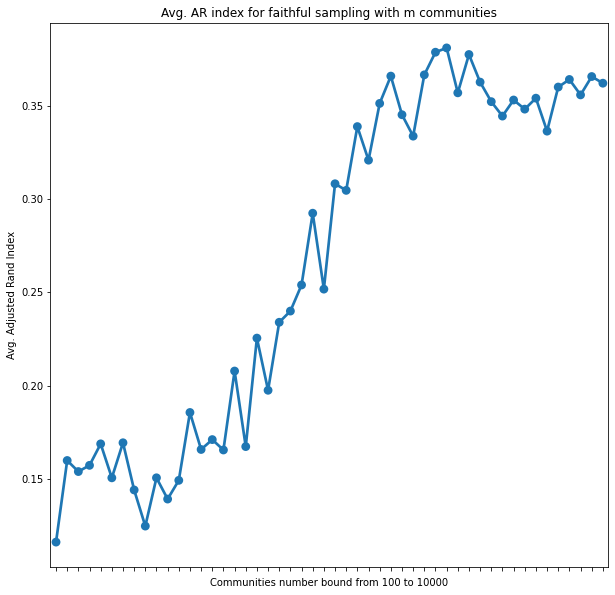

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = sns.pointplot(x = ms, y = ars)
ax.set_xlabel("Communities number bound from 100 to 10000")
ax.set_ylabel("Avg. Adjusted Rand Index")
ax.set_title("Avg. AR index for faithful sampling with m communities no. bound")
ax.set_xticklabels("")

#### 5.3 Spectral clustering avg. time for trivial method vs with faithful sampling

In [112]:
# Function measures elapsed time (in seconds) taken by performing trivial spectral clustering
# returns: elapsed time in seconds
def measureTimeTrivialSpectral():
    start = time.time()
    spectralClustering(X, n_of_clusters=3, nodeRepresentationDim=3, M=M)
    end = time.time()
    
    return end- start

# Function measures elapsed time (in seconds) taken by performing spectral clustering with faithful sampling
#
# no_of_communities - bound of number of communities
# returns: elapsed time in seconds
def measureTimeFaithfulSpectral(no_of_communities):
    start = time.time()
    spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=M, communities_no=int(no_of_communities))
    end = time.time()
    
    return end- start

# measuring differences in performance time for trivial spectral clustering vs the one with faithful sampling
# for no. of neighbours M = 4
M = 4
communities_no = np.linspace(100, 10000, 50)

times_trivial = []
times_sampling = []

for no in communities_no:
    diff_trivial = measureTimeTrivialSpectral()
    times_trivial.append(diff_trivial)
    
    diff_sampling = measureTimeFaithfulSpectral(no)
    times_sampling.append(diff_sampling)

    diff = diff_trivial - diff_sampling
    print(f'Time for trivial: {round(diff_trivial,2)}s, Time for sampling: {round(diff_sampling, 2)}s, difference: {round(diff, 2)}s')

print(f'Avg. time for trivial method: {round(mean(times_trivial),2)}s')
print(f'Avg. time for method with sampling: {round(mean(times_sampling),2)}s')

Shape of node representation: (1500, 3)
Number of communities: 16
Shape of node representation: (16, 3)
Time for trivial: 3.62s, Time for sampling: 0.41s, difference: 3.21s
Shape of node representation: (1500, 3)
Number of communities: 41
Shape of node representation: (41, 3)
Time for trivial: 3.58s, Time for sampling: 0.58s, difference: 3.0s
Shape of node representation: (1500, 3)
Number of communities: 49
Shape of node representation: (49, 3)
Time for trivial: 3.76s, Time for sampling: 0.98s, difference: 2.78s
Shape of node representation: (1500, 3)
Number of communities: 56
Shape of node representation: (56, 3)
Time for trivial: 4.54s, Time for sampling: 1.17s, difference: 3.36s
Shape of node representation: (1500, 3)
Number of communities: 59
Shape of node representation: (59, 3)
Time for trivial: 4.7s, Time for sampling: 1.12s, difference: 3.57s
Shape of node representation: (1500, 3)
Number of communities: 65
Shape of node representation: (65, 3)
Time for trivial: 4.41s, Time for

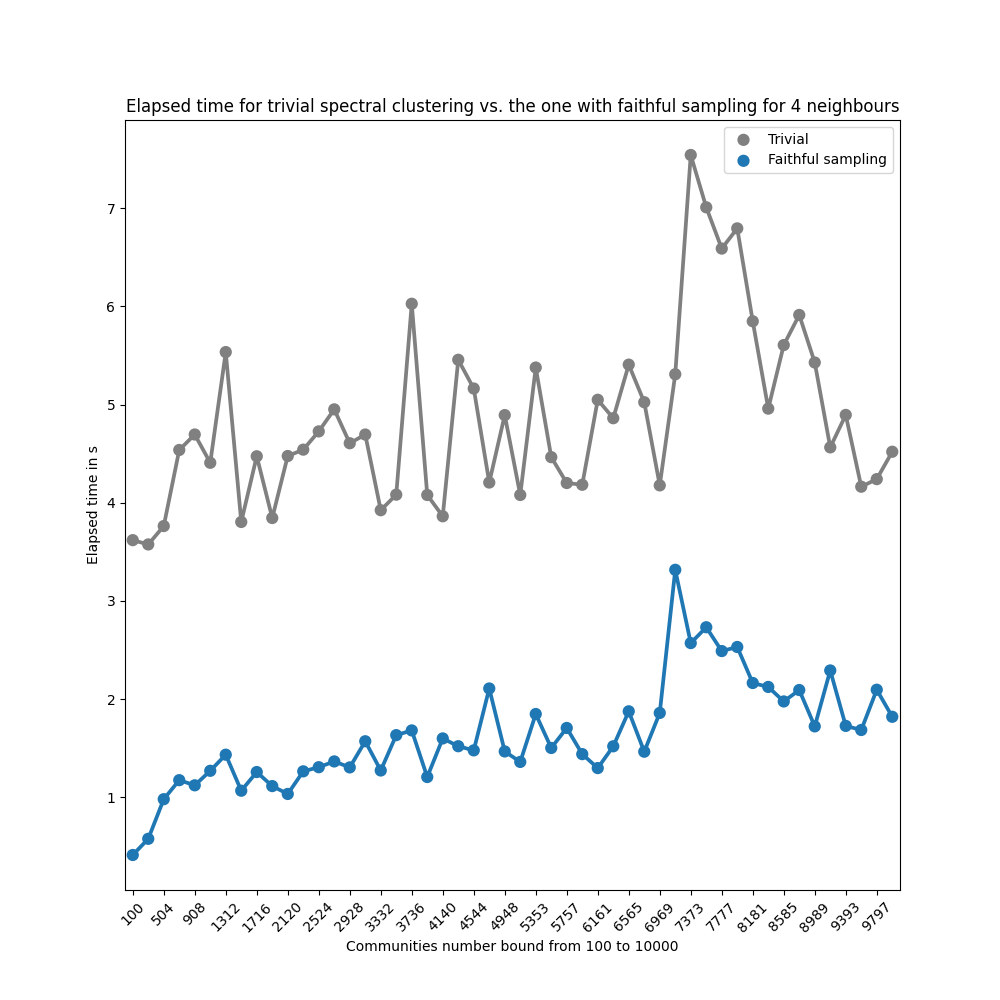

In [114]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

communities_rounded = [ int(x) for x in communities_no ]

ax = sns.pointplot(x = communities_rounded, y = times_trivial, color='.5', label='Trivial')
ax = sns.pointplot(x = communities_rounded, y = times_sampling, label='Faithful sampling')
ax.set_xlabel("Communities number bound from 100 to 10000")
ax.set_ylabel("Elapsed time in s")
ax.set_title(f"Elapsed time for trivial spectral clustering vs. the one with faithful sampling for {M} neighbours")
ax.legend()

ax.xaxis.set_major_locator(ticker.MultipleLocator(2))

for item in ax.get_xticklabels():
    item.set_rotation(45)

#### 5.4 Spectral clustering with faithful sampling vs M neighbours

In [ ]:
# verifying the obtained results of spectral clustering with faithful sampling for numbers of M neighbours
# for 8000 communities bound
neighbours = np.linspace(2, 100, 50)
samples_no = 20
ars = []

for M in neighbours:
    sum = 0
    for i in range(samples_no):
        spectral_labels = spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=M, communities_no=8000)
        sum += AR(spectral_labels, labels[0])
        
    print(f'Neighbours no. = {str(M)}')
    ars.append(sum / samples_no)


Number of communities: 124
Shape of node representation: (124, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 130
Shape of node representation: (130, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 124
Shape of node representation: (124, 3)
Number of communities: 127
Shape of node representation: (127, 3)
Number of communities: 125
Shape of node representation: (125, 3)
Number of communities: 127
Shape of node representation: (127, 3)
Number of communities: 128
Shape of node representation: (128, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Number of communities: 125
Shape of node representation: (125, 3)
Number of 

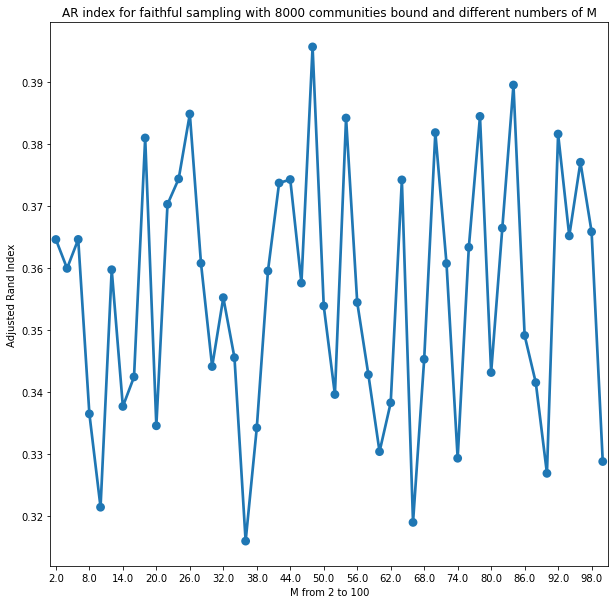

In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

ax = sns.pointplot(x = neighbours, y = ars)
ax.set_xlabel("M from 2 to 100")
ax.set_ylabel("Adjusted Rand Index")
ax.set_title("AR index for faithful sampling with 8000 communities bound and different numbers of M")

ax.xaxis.set_major_locator(ticker.MultipleLocator(3))

#### 5.5 Faithful sampling with connecting distances vs trivial connecting - AR comparision for different M neighbours

In [115]:
# verifying the obtained results of spectral clustering with faithful sampling for numbers of M neighbours
# for 8000 communities bound
samples_no = 20

ars_distances = []
ars_trivial = []

for M in range(2,20):
    sum_trivial = 0
    sum_distances = 0

    for i in range(samples_no):
        spectral_labels_trivial = spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=M, communities_no=8000)
        spectral_labels_distances = spectralClusteringUsingFaithfulAndDistancesCombinedPercentages(X, n_of_clusters=3, M=2, nodeRepresentationDim=3, MST=10, communities_no=8000)
        
        sum_trivial += AR(spectral_labels_trivial, labels[0])
        sum_distances += AR(spectral_labels_distances, labels[0])
        
    ars_trivial.append(sum_trivial / samples_no)
    ars_distances.append(sum_distances / samples_no)

Number of communities: 129
Shape of node representation: (129, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of communities: 127
Shape of node representation: (127, 3)
Number of communities: 122
Shape of node representation: (122, 3)
Number of communities: 124
Shape of node representation: (124, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Number of communities: 129
Shape of node representation: (129, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Number of communities: 122
Shape of node representation: (122, 3)
Number of communities: 125
Shape of node representation: (125, 3)
Number of communities: 127
Shape of node representation: (127, 3)
Number of communities: 127
Shape of node representation: (127, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Number of 

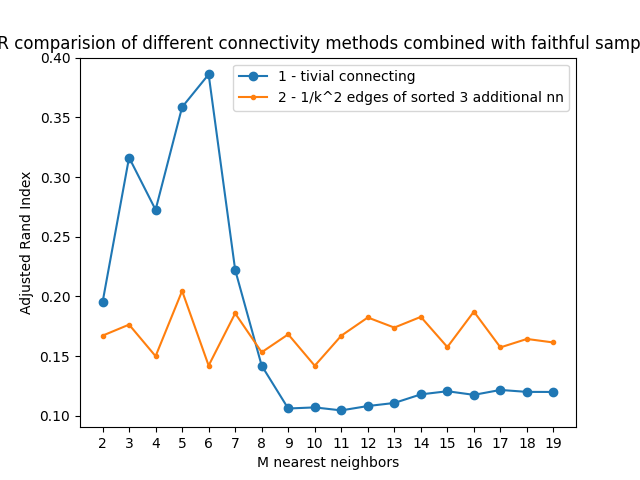

In [116]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(ars_trivial), marker='o')
ax.plot(xs, np.array(ars_distances), marker='.')

ax.legend( ['1 - tivial connecting', '2 - 1/k^2 edges of sorted 3 additional nn'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('Adjusted Rand Index')

ax.set_title("AR comparision of different connectivity methods combined with faithful sampling")

plt.xticks(xs, (xs).astype(int))
plt.show()

In [119]:
# Function measures elapsed time (in seconds) taken by performing trivial spectral clustering with faithful sampling
# returns: elapsed time in seconds
def measureTimeTrivialConnectFaithfulSpectral(M):
    start = time.time()
    spectralClusteringWithFaithful(X, n_of_clusters=3, nodeRepresentationDim=3, M=M, communities_no=8000)
    end = time.time()
    
    return end- start

# Function measures elapsed time (in seconds) taken by performing spectral clustering with faithful sampling and connectivity with distances
#
# M - number of neighbours
# returns: elapsed time in seconds
def measureTimeDistanceConnectFaithfulSpectral(M):
    start = time.time()
    spectralClusteringUsingFaithfulAndDistancesCombinedPercentages(X, n_of_clusters=3, M=M, nodeRepresentationDim=3, MST=25, communities_no=8000)
    end = time.time()
    
    return end- start

# measuring differences in performance time for trivial spectral clustering with faithful sampling vs spectral clustering with faithful sampling and connectivity with distances
# for no. of communities 8000

times_trivial = []
times_distances = []

for no in range(2,20):
    diff_trivial = measureTimeTrivialConnectFaithfulSpectral(M)
    times_trivial.append(diff_trivial)
    
    diff_distances = measureTimeDistanceConnectFaithfulSpectral(M)
    times_distances.append(diff_distances)

    diff = diff_trivial - diff_distances
    print(f'Time for trivial: {round(diff_trivial,2)}s, Time for distances: {round(diff_distances, 2)}s, difference: {round(diff, 2)}s')

print(f'Avg. time for trivial method: {round(mean(times_trivial),2)}s')
print(f'Avg. time for method with distance connectivity: {round(mean(times_distances),2)}s')

Number of communities: 122
Shape of node representation: (122, 3)
Number of communities: 123
Shape of node representation: (123, 3)
Time for trivial: 1.32s, Time for distances: 1.26s, difference: 0.06s
Number of communities: 128
Shape of node representation: (128, 3)
Number of communities: 117
Shape of node representation: (117, 3)
Time for trivial: 1.13s, Time for distances: 1.22s, difference: -0.09s
Number of communities: 127
Shape of node representation: (127, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Time for trivial: 1.0s, Time for distances: 1.27s, difference: -0.28s
Number of communities: 122
Shape of node representation: (122, 3)
Number of communities: 124
Shape of node representation: (124, 3)
Time for trivial: 1.03s, Time for distances: 1.16s, difference: -0.12s
Number of communities: 126
Shape of node representation: (126, 3)
Number of communities: 126
Shape of node representation: (126, 3)
Time for trivial: 1.02s, Time for distances: 1.11s, differ

In [ ]:
xs = np.array(list(range(2,20)))

fig = plt.figure()
ax = fig.add_subplot()

ax.plot(xs, np.array(times_trivial), marker='o')
ax.plot(xs, np.array(times_distances), marker='.')

ax.legend( ['1 - tivial connecting time', '2 - 1/k^2 edges of sorted 3 additional nn time'])

ax.set_xlabel('M nearest neighbors')
ax.set_ylabel('time [s]')

ax.set_title("Time comparision of different connectivity methods combined with faithful sampling")

plt.xticks(xs, (xs).astype(int))
plt.show()

### 6. Animation and initial data representation
Visualization prepared for trivial clustering

In [86]:
%matplotlib widget

# Function gets node representation of spectral clustering with distances used in animation
def getRepresentationOfDistances():
    percs = np.linspace(0.05,0.5, 10)

    zs = list()
    
    for perc in percs:
        Z, _ = spectralClusteringUsingDistances(X, n_of_clusters=3, M=3, nodeRepresentationDim=3, MST=4, perc=perc)
        zs.append(Z)

    return zs

# Function performs the animation of trivial spectral clustering
def animateSpectralClustering(i):
    ax = fig.add_subplot(111, projection='3d')
    ax.clear()

    ms = np.linspace(2, 100, 50)
    ms2 = np.flip(ms)
    m =  ms2[i]
    nr = spectralNR(X, M=int(m), nodeRepresentationDim=3)

    print(np.max(nr))
    print(np.min(nr))

    ax.scatter(nr[:,0], nr[:,1], nr[:,2], marker='.', c = labels[0])
    ax.set_title("Node representation - decreasing M 100 to 2")
    ax.set_xlim([-0.1, 0.1])
    ax.set_ylim([-0.1, 0.1])
    ax.set_zlim([-0.1, 0.1])

# Function performs the animation of spectral clustering with distances
def animateSpectralClusteringDistances(i):
    ax = fig.add_subplot(111, projection='3d')
    ax.clear()

    z = getRepresentationOfDistances()
    nr = z[min(i , len(z) -1)]

    ax.scatter(nr[:,0], nr[:,1], nr[:,2], marker='.', c = labels[0])
    ax.set_title("Node representation - adding edges M 2 to 15")
    ax.set_xlim([-0.2, 0.2])
    ax.set_ylim([-0.2, 0.2])
    ax.set_zlim([-0.2, 0.2])

# Function used to plot in 3D the initial representation of the data
def plotInitialDataRepresentation():

    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10,10,10)

    ms = np.linspace(2, 100, 50)

    ax = fig.add_subplot(111, projection='3d')
    ax.clear()

    ax.scatter(X[:,0], X[:,1], X[:,2], marker='.', c = labels[0])
    ax.set_title("Initial node representation")
    ax.set_xlim([-3, 3])
    ax.set_ylim([-3, 3])
    ax.set_zlim([-3, 3])

    plt.show()

# Function used to plot in 3D the data representation after clustering for M neighbours
#
# M - number of neighbours used in KNN
def plotDataRepresentationForMNeighbours(M):
    fig, ax = plt.subplots(1, 1)
    fig.set_size_inches(10,10,10)

    ax = fig.add_subplot(111, projection='3d')
    ax.clear()
    nr = spectralNR(X, M=M, nodeRepresentationDim=3)

    ax.scatter(nr[:,0], nr[:,1], nr[:,2], marker='.', c = labels[0])
    ax.set_title(f'Node representation - M = {M}')
    ax.set_xlim([-0.2, 0.2])
    ax.set_ylim([-0.2, 0.2])
    ax.set_zlim([-0.2, 0.2])

    plt.show()


In [ ]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

animTrivial = FuncAnimation(fig, animateSpectralClustering, frames=50, interval=400, repeat=False)
plt.close()

# Save the animation of trivial spectral clustering as an animated GIF
animTrivial.event_source.stop()
animTrivial.save("node-representation-animation.gif", dpi=300, writer=PillowWriter(fps=5))

C:\Users\zosia\AppData\Roaming\Python\Python38\site-packages\matplotlib\animation.py:879: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you output the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


0.06341853008719435
-0.048932353489990206
0.06341853008719435
-0.048932353489990206
0.04918682535895411
-0.06305219377196357
0.062435584808221034
-0.049630648821408864
0.062179691421798244
-0.05058760374306143
0.061707096658811716
-0.05122569265029864
0.061268483785128565
-0.05171951396917546
0.052784237889275935
-0.061102751792972775
0.060750241903126036
-0.056627198268854095
0.06029098771203623
-0.04983080932856534
0.050461408613335
-0.06008084591503134
0.05147247167341398
-0.05959481994704802
0.05198590284456938
-0.05936913015019137
0.059477724331795344
-0.046689374234229336
0.052849039510714506
-0.05962718215815462
0.05320745423823004
-0.059509974428060816
0.05942536993329858
-0.04621013043000628
0.0530921829662402
-0.05954170905365212
0.053120468176385244
-0.0597806482138168
0.0601422952250079
-0.05282596545357253
0.06053628107950114
-0.05263458921878494
0.04789132471791321
-0.061175771058811404
0.06196270568857863
-0.04800970372366148
0.04814484875158802
-0.062426069785956835
0.0

In [87]:
fig, ax = plt.subplots(1, 1)
fig.set_size_inches(10,10,10)

animDistances = FuncAnimation(fig, animateSpectralClusteringDistances, frames=50,
                    interval=400, repeat=False)
plt.close()

# Save the animation of spectral clustering with distances as an animated GIF
animDistances.event_source.stop()
animDistances.save("node-representation-animation-distances.gif", dpi=300, writer=PillowWriter(fps=2))

A.sum() = 4218.0
A is symmetric: True
A.sum() = 4316.0
A is symmetric: True
A.sum() = 4420.0
A is symmetric: True
A.sum() = 4518.0
A is symmetric: True
A.sum() = 4618.0
A is symmetric: True
A.sum() = 4730.0
A is symmetric: True
A.sum() = 4826.0
A is symmetric: True
A.sum() = 4934.0
A is symmetric: True
A.sum() = 5046.0
A is symmetric: True
A.sum() = 5158.0
A is symmetric: True
A.sum() = 4218.0
A is symmetric: True
A.sum() = 4316.0
A is symmetric: True
A.sum() = 4420.0
A is symmetric: True
A.sum() = 4518.0
A is symmetric: True
A.sum() = 4618.0
A is symmetric: True
A.sum() = 4730.0
A is symmetric: True
A.sum() = 4826.0
A is symmetric: True
A.sum() = 4934.0
A is symmetric: True
A.sum() = 5046.0
A is symmetric: True
A.sum() = 5158.0
A is symmetric: True
A.sum() = 4218.0
A is symmetric: True
A.sum() = 4316.0
A is symmetric: True
A.sum() = 4420.0
A is symmetric: True
A.sum() = 4518.0
A is symmetric: True
A.sum() = 4618.0
A is symmetric: True
A.sum() = 4730.0
A is symmetric: True
A.sum() = 48

KeyboardInterrupt: 

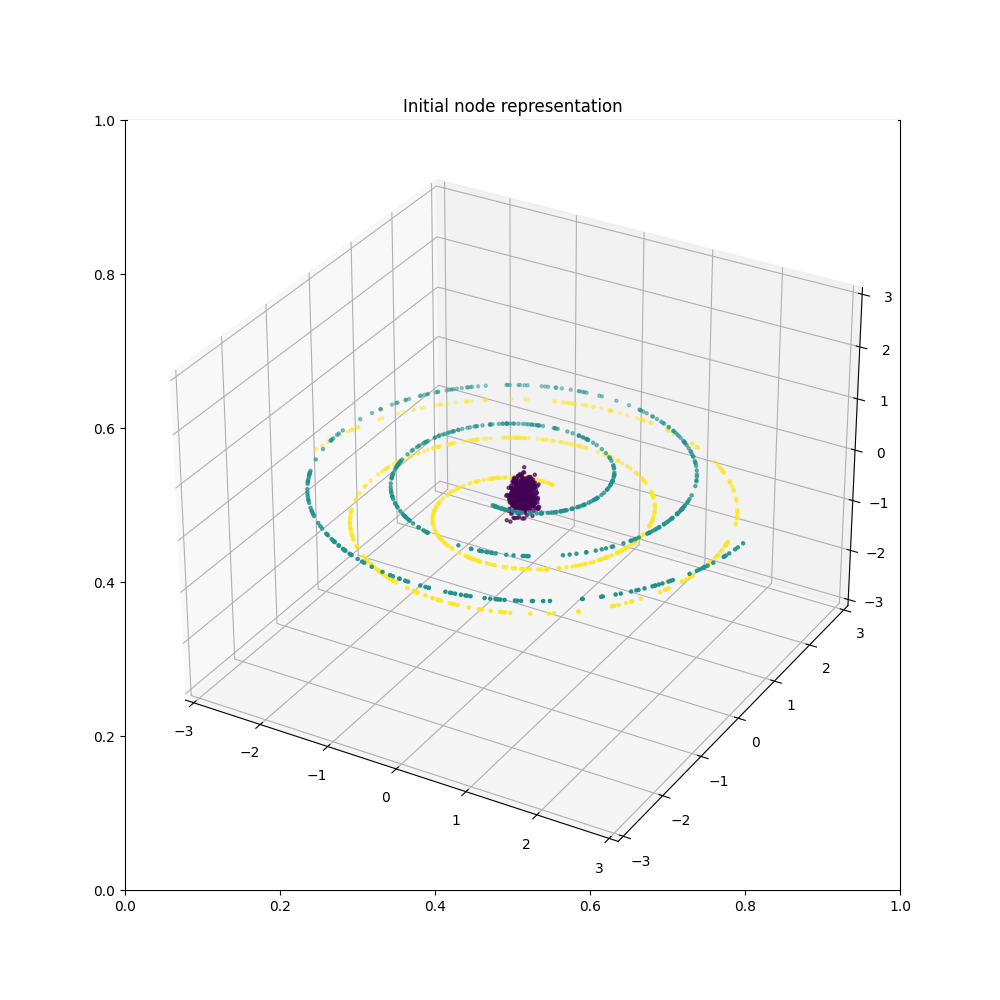

In [30]:
# Plotting intial data representation
plotInitialDataRepresentation()

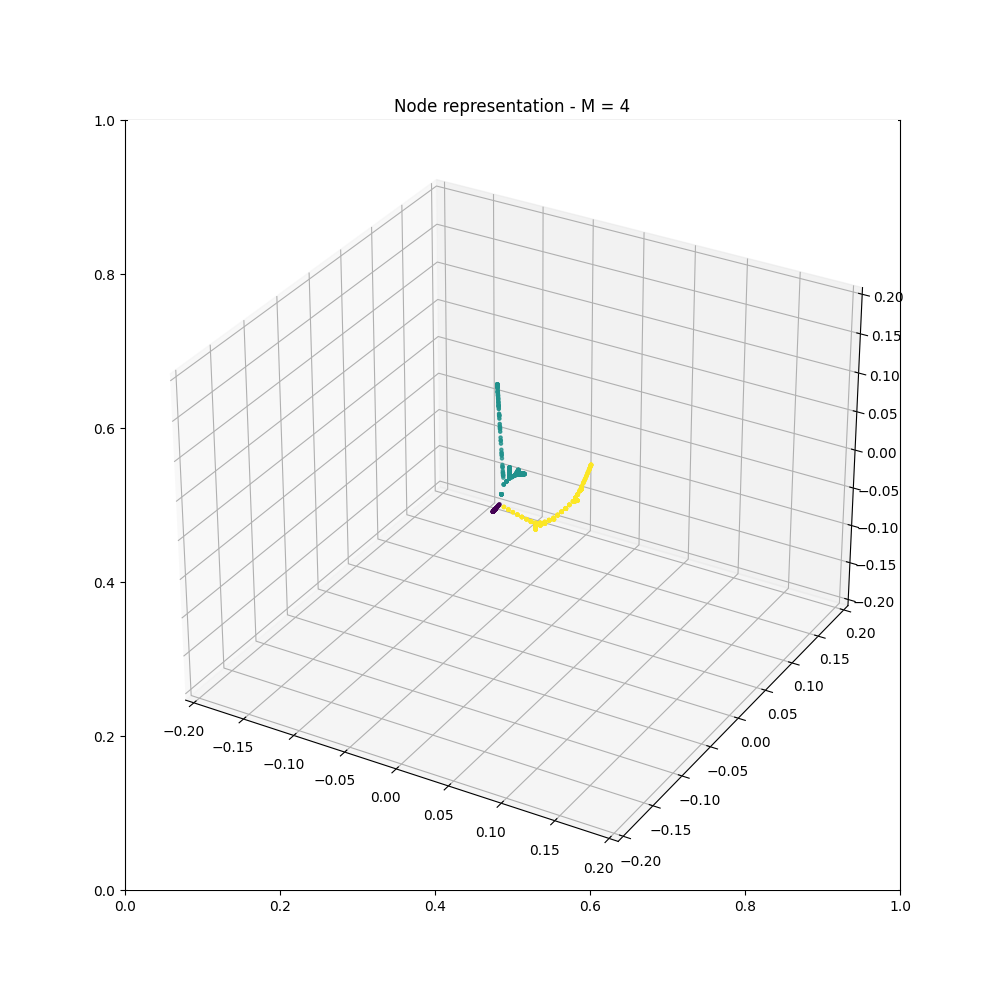

In [33]:
# Plotting representation for M = 4
plotDataRepresentationForMNeighbours(4)

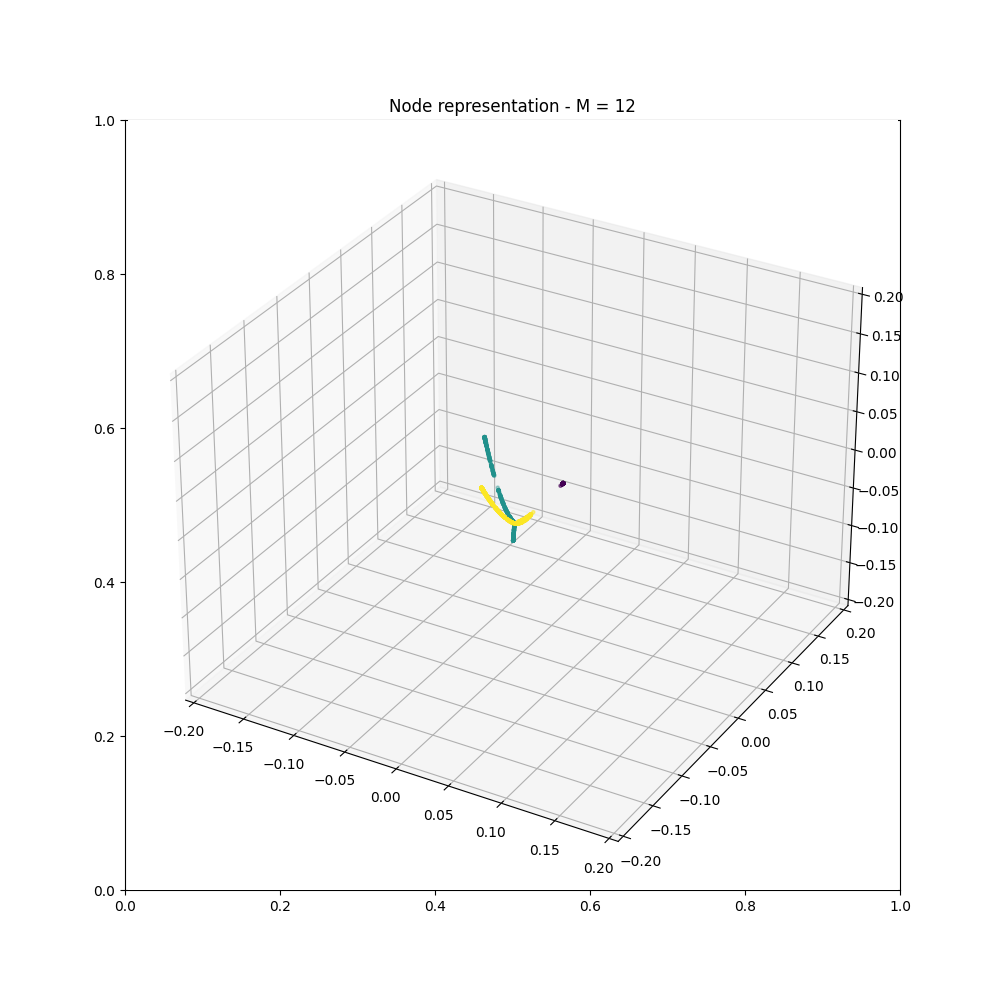

AttributeError: 'PolyCollection' object has no attribute 'do_3d_projection'

In [34]:
# Plotting representation for M = 12
plotDataRepresentationForMNeighbours(12)